<a href="https://colab.research.google.com/github/Cimbir/Facial-Expression-Recognition/blob/main/nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
!pip install kaggle wandb onnx -Uq
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 77.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!echo "{\"username\":\"dachisuramelashvili\",\"key\":\"4202ec60e20b612a9947450bb8aeebb5\"}" > ~/.kaggle
!cp /content/drive/MyDrive/ML/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: /root/.kaggle: Is a directory


In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

 97% 278M/285M [00:00<00:00, 480MB/s]
100% 285M/285M [00:00<00:00, 473MB/s]
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory
import random
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac

print("Device available: ", device)

Device available:  cuda


# Get Data

In [ ]:
data = pd.read_csv("train.csv")

In [ ]:
data.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def display_faces(image_data_list, num_images_to_display, image_shape=(48, 48)):
  """
  Displays a specified number of images side by side from a list of image data.

  Args:
    image_data_list: A list of image data (e.g., pixel strings or NumPy arrays).
    num_images_to_display: The number of images to display.
    image_shape: A tuple representing the shape of each image (height, width).
  """
  image_data_list = image_data_list['pixels'].tolist()

  # Ensure we don't try to display more images than available
  actual_images_to_display = min(num_images_to_display, len(image_data_list))

  print(f"Attempting to display {num_images_to_display} images.")
  if actual_images_to_display < num_images_to_display:
      print(f"Warning: Only {actual_images_to_display} images available in the list.")

  plt.figure(figsize=(actual_images_to_display * 3, 3))

  for i in range(actual_images_to_display):
    plt.subplot(1, actual_images_to_display, i + 1)

    image_data = image_data_list[i]

    if isinstance(image_data, str):
      pixel_list = [int(pixel) for pixel in image_data.split()]
      image_array = np.array(pixel_list).reshape(image_shape)
    elif isinstance(image_data, np.ndarray):
      image_array = image_data.reshape(image_shape)
    else:
      print(f"Warning: Unsupported image data type at index {i}. Skipping.")
      continue

    image = Image.fromarray(image_array.astype(np.uint8))

    plt.imshow(image, cmap='gray')
    plt.axis('off')

  plt.tight_layout()
  plt.show()

Attempting to display 15 images.


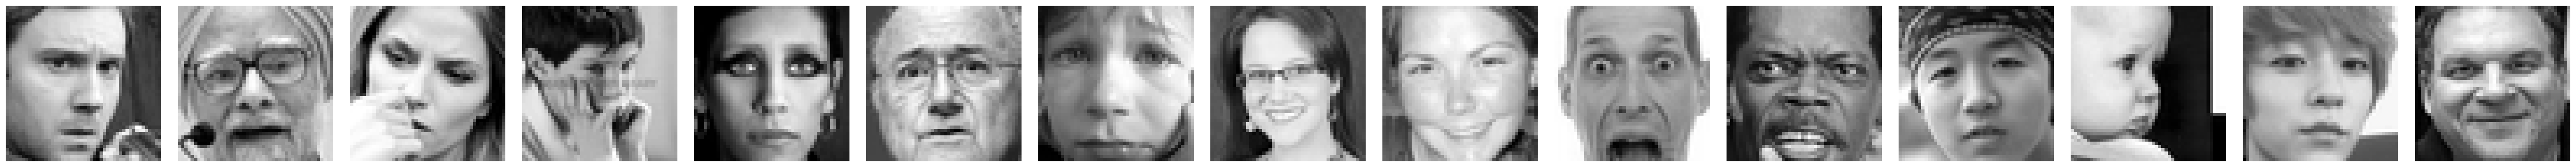

In [ ]:
display_faces(data, 15)

In [ ]:
train=data.sample(frac=0.8,random_state=42)
val=data.drop(train.index)

In [ ]:
val.shape, train.shape

((5742, 2), (22967, 2))

# Preprocess

In [ ]:
LR=1e-3
BATCH_SIZE=16
EPOCHS=10

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.flatten())
])

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np
from PIL import Image

class FacialExpressionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_pixels = self.dataframe.iloc[idx]['pixels']
        label = int(self.dataframe.iloc[idx]['emotion'])  # still int here
        label = torch.tensor(label, dtype=torch.long)     # convert to tensor

        pixel_list = [int(pixel) for pixel in img_pixels.split()]
        image_array = np.array(pixel_list).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image_array, mode='L')

        if self.transform:
            image = self.transform(image)  # keep on CPU

        return image, label


In [ ]:
def to_loader(dataframe, transform, batch_size):
  dataset = FacialExpressionDataset(dataframe, transform)
  loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  return loader

In [ ]:
dataset = FacialExpressionDataset(data, transform)

In [ ]:
dataset.__getitem__(3)

(tensor([0.0941, 0.1255, 0.1412,  ..., 0.5569, 0.5608, 0.5569]), tensor(4))

# Model

In [ ]:
class BaseNN(nn.Module):
  def __init__(self, hidden_dims: list[int] = [], normalization: str = '', dropout: float = 0):
    super().__init__()

    dims = [48*48] + hidden_dims + [7]

    l = len(dims)
    self.layers = nn.ModuleList()
    for i in range(l-2):
      self.layers.append(nn.Linear(dims[i], dims[i+1]))
      if normalization == 'batch':
        self.layers.append(nn.BatchNorm1d(dims[i+1]))
      elif normalization == 'layer':
        self.layers.append(nn.LayerNorm(dims[i+1]))
      self.layers.append(nn.ReLU())
      if dropout > 0:
        self.layers.append(nn.Dropout(dropout))
    self.layers.append(nn.Linear(dims[l-2], dims[l-1]))

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
def get_model(config):
  return BaseNN(config['hidden_dims'], config['normalization'], config['dropout']).to(device)

In [ ]:
config = {
    'learning_rate': 1e-3,
    'epochs': 10,
    'batch_size': 16,
    'hidden_dims': [1024],
    'normalization': 'none',
    'dropout': 0.0,
    'architecture': 'Simple NN'
}

In [ ]:
model = get_model(config)

In [ ]:
from torchsummary import summary
summary(model, input_size = (48*48, ), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       2,360,320
              ReLU-2                 [-1, 1024]               0
            Linear-3                    [-1, 7]           7,175
Total params: 2,367,495
Trainable params: 2,367,495
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 9.03
Estimated Total Size (MB): 9.06
----------------------------------------------------------------


# Training Definitions

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [ ]:
import torch
import time

def train_model(model, data, criterion, optimizer, num_epochs=10, device='cuda', log=1, is_overfit=False):
  if log > 1 and not is_overfit:
    print('HEREHERHERHERHEHEhER')
    wandb.watch(model, criterion, log='all', log_freq=10)

  train_loader = data['train']
  val_loader = data['val']

  history = {
      'train_loss': [],
      'val_loss': [],
      'train_acc': [],
      'val_acc': [],
      'grad/weight_ratio': [],
      'weight_norm': []
  }

  model.to(device)

  for epoch in range(num_epochs):
    start_time = time.time()

    # ---- TRAINING ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    total_grad = 0.0
    total_weight = 0.0
    current_grad_ratio = 0.0
    total_grad_ratio = []
    avg_grad_ratio = 0.0

    for batch_idx, (images, labels) in enumerate(train_loader):
      # Forward/Backward
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()

      # Grad ration calculation
      for param in model.parameters():
        if param.grad is not None:
          total_grad += param.grad.norm().item()
          total_weight += param.data.norm().item()

      if total_weight > 0:
        current_grad_ratio = (total_grad / total_weight) * 100
      else:
        current_grad_ratio = 0.0

      total_grad_ratio.append(current_grad_ratio)

      # Update
      optimizer.step()

      running_loss += loss.item() * images.size(0)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

      if log > 0 and batch_idx % 200 == 0 and not is_overfit:
          print(f"[Epoch {epoch+1}/{num_epochs}] "
                f"Batch {batch_idx}/{len(train_loader)} - "
                f"Loss: {loss.item():.4f} - "
                f"Processed: {total} images - "
                f"Grad/weight_ratio: {current_grad_ratio:.2%}")


    train_loss = running_loss / total
    train_acc = correct / total
    avg_grad_ratio = sum(total_grad_ratio) / len(total_grad_ratio)

    # ---- VALIDATION ----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
      for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        val_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

    val_loss /= val_total
    val_acc = val_correct / val_total

    weight_norm = sum(p.data.norm().item() for p in model.parameters())

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['grad/weight_ratio'].append(avg_grad_ratio)
    history['weight_norm'].append(weight_norm)

    overfit_suffix = '_overfit' if is_overfit else ''

    if log > 0:
      elapsed = time.time() - start_time
      print(f"\nEpoch [{epoch+1}/{num_epochs}] completed in {elapsed:.1f}s")
      print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
      print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2%}")
      print(f"Grad/Weight Ratio: {avg_grad_ratio:.2%}")
      print(f"Weight Norm: {weight_norm:.2f}\n")
    if log > 1:
      wandb.log({
          f"epoch{overfit_suffix}": epoch+1,
          f"train_loss{overfit_suffix}": train_loss,
          f"train_acc{overfit_suffix}": train_acc,
          f"val_loss{overfit_suffix}": val_loss,
          f"val_acc{overfit_suffix}": val_acc,
          f"grad/weight_ratio{overfit_suffix}": avg_grad_ratio,
          f"weight_norm{overfit_suffix}": weight_norm})


  return history


# Training

In [ ]:
def overfit(config, wandb=False):
  model = get_model(config)
  optimizer = Adam(model.parameters(), lr=config['learning_rate'])

  overfit_data = {
      'train': to_loader(train[:16], transform=transform, batch_size=config['batch_size']),
      'val': to_loader(val[:16], transform=transform, batch_size=config['batch_size'])
  }

  return train_model(model, overfit_data, criterion, optimizer, 100, device, 2 if wandb else 1, True)

In [ ]:
overfit_history = overfit(config)


Epoch [1/100] completed in 0.0s
Train Loss: 1.9412 | Train Acc: 12.50%
Val   Loss: 28.2063 | Val   Acc: 6.25%
Grad/Weight Ratio: 2150.01%
Weight Norm: 21.71


Epoch [2/100] completed in 0.0s
Train Loss: 16.0312 | Train Acc: 31.25%
Val   Loss: 13.1949 | Val   Acc: 37.50%
Grad/Weight Ratio: 34923.76%
Weight Norm: 22.81


Epoch [3/100] completed in 0.0s
Train Loss: 13.9032 | Train Acc: 18.75%
Val   Loss: 8.5315 | Val   Acc: 12.50%
Grad/Weight Ratio: 39832.56%
Weight Norm: 23.91


Epoch [4/100] completed in 0.0s
Train Loss: 10.1207 | Train Acc: 31.25%
Val   Loss: 7.6200 | Val   Acc: 12.50%
Grad/Weight Ratio: 26703.85%
Weight Norm: 25.05


Epoch [5/100] completed in 0.0s
Train Loss: 7.3124 | Train Acc: 37.50%
Val   Loss: 9.3045 | Val   Acc: 6.25%
Grad/Weight Ratio: 21525.10%
Weight Norm: 26.20


Epoch [6/100] completed in 0.0s
Train Loss: 5.9529 | Train Acc: 6.25%
Val   Loss: 6.0520 | Val   Acc: 6.25%
Grad/Weight Ratio: 25225.00%
Weight Norm: 27.35


Epoch [7/100] completed in 0.0s
Train L

In [ ]:
model = get_model(config)
optimizer = Adam(model.parameters(), lr=LR)

training_data = {
    'train': to_loader(train, transform=transform, batch_size=config['batch_size']),
    'val': to_loader(val, transform=transform, batch_size=config['batch_size'])
}

history = train_model(model, training_data, criterion, optimizer, 5, device, True)

[Epoch 1/5] Batch 0/1436 - Loss: 1.8844 - Processed: 16 images - Grad/weight_ratio: 36.43%
[Epoch 1/5] Batch 200/1436 - Loss: 1.7956 - Processed: 3216 images - Grad/weight_ratio: 56.22%
[Epoch 1/5] Batch 400/1436 - Loss: 1.7238 - Processed: 6416 images - Grad/weight_ratio: 63.94%
[Epoch 1/5] Batch 600/1436 - Loss: 1.8361 - Processed: 9616 images - Grad/weight_ratio: 77.15%


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-72-e90e3a43da3c>", line 9, in <cell line: 0>
    history = train_model(model, training_data, criterion, optimizer, 5, device, True)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-69-9ba83411f5b5>", line 37, in train_model
    for batch_idx, (images, labels) in enumerate(train_loader):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/

TypeError: object of type 'NoneType' has no len()

# Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, is_overfit=False):
    """
    Plots training and validation loss, accuracy, gradient-to-weight ratio, and weight norm.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(24, 5))

    # ---- LOSS ----
    plt.subplot(1, 4, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # ---- ACCURACY ----
    plt.subplot(1, 4, 2)
    plt.plot(epochs, history['train_acc'], label='Train Acc', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Acc', marker='o')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # ---- GRADIENT-TO-WEIGHT RATIO ----
    plt.subplot(1, 4, 3)
    plt.plot(epochs, history['grad/weight_ratio'], label='Grad/Weight Ratio', marker='o', color='purple')
    plt.title('Grad-to-Weight Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio (%)')
    plt.legend()
    plt.grid(True)

    # ---- WEIGHT NORM ----
    plt.subplot(1, 4, 4)
    plt.plot(epochs, history['weight_norm'], label='Weight Norm', marker='o', color='darkgreen')
    plt.title('Weight Norm over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Norm (L2)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"training_plot{'_overfit' if is_overfit else ''}.png")
    plt.show()


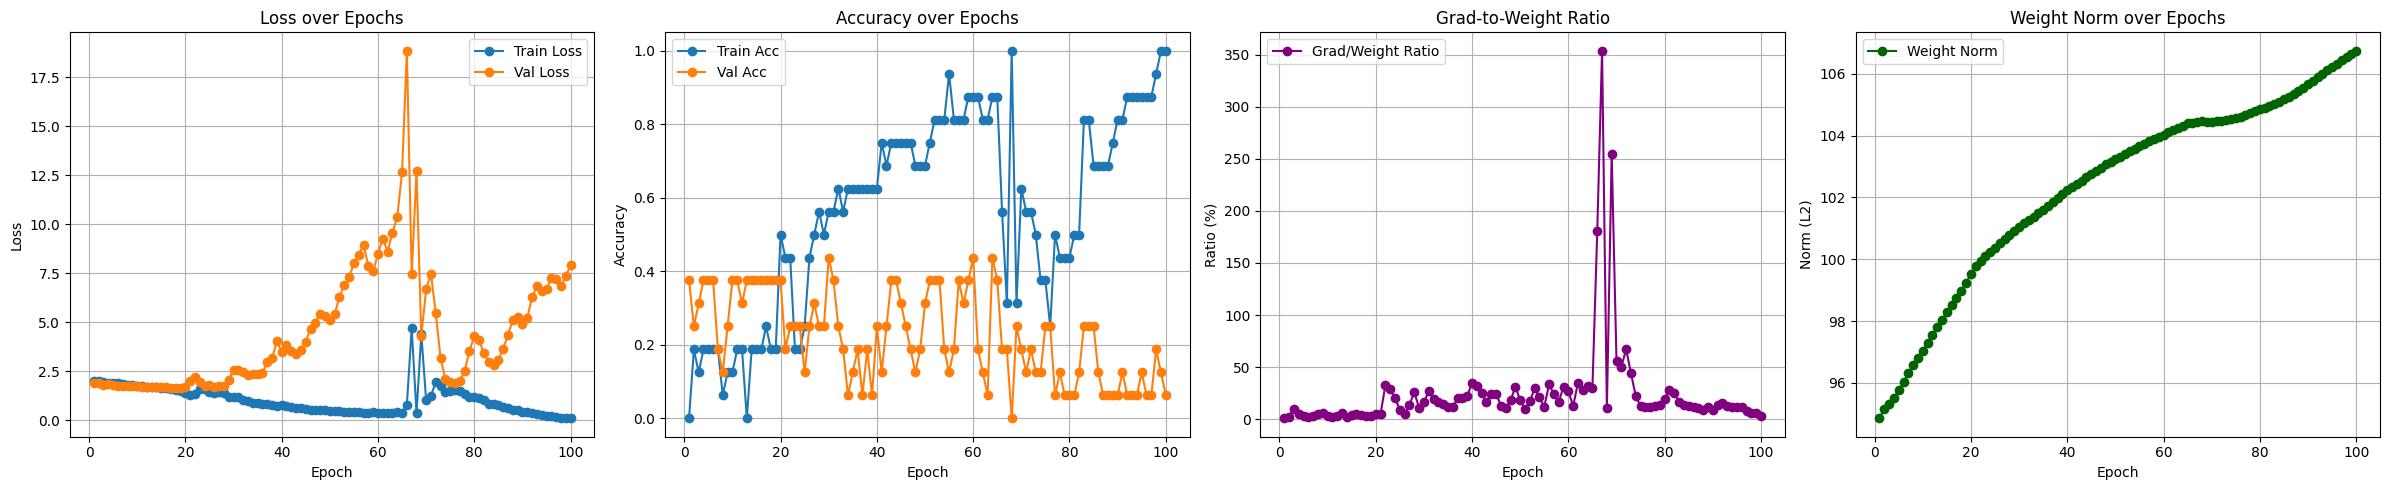

In [ ]:
plot_training_history(overfit_history)

# Model Pipeline

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dachis (dachis-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
config = {
    'learning_rate': 1e-3,
    'epochs': 10,
    'batch_size': 16,
    'hidden_dims': [1024],
    'normalization': 'none',
    'dropout': 0.0,
    'architecture': '1-Layer-NN'
}

overfit


Epoch [1/100] completed in 0.0s
Train Loss: 1.9450 | Train Acc: 6.25%
Val   Loss: 4.7848 | Val   Acc: 6.25%
Grad/Weight Ratio: 2142.11%
Weight Norm: 20.46


Epoch [2/100] completed in 0.0s
Train Loss: 2.6664 | Train Acc: 31.25%
Val   Loss: 2.2305 | Val   Acc: 37.50%
Grad/Weight Ratio: 9273.73%
Weight Norm: 20.51


Epoch [3/100] completed in 0.0s
Train Loss: 2.1118 | Train Acc: 18.75%
Val   Loss: 2.0854 | Val   Acc: 12.50%
Grad/Weight Ratio: 9120.80%
Weight Norm: 20.56


Epoch [4/100] completed in 0.0s
Train Loss: 1.9638 | Train Acc: 31.25%
Val   Loss: 2.3284 | Val   Acc: 12.50%
Grad/Weight Ratio: 7452.09%
Weight Norm: 20.62


Epoch [5/100] completed in 0.0s
Train Loss: 1.6583 | Train Acc: 43.75%
Val   Loss: 2.8649 | Val   Acc: 12.50%
Grad/Weight Ratio: 6191.91%
Weight Norm: 20.68


Epoch [6/100] completed in 0.0s
Train Loss: 1.4044 | Train Acc: 56.25%
Val   Loss: 3.4666 | Val   Acc: 6.25%
Grad/Weight Ratio: 4598.10%
Weight Norm: 20.74


Epoch [7/100] completed in 0.0s
Train L

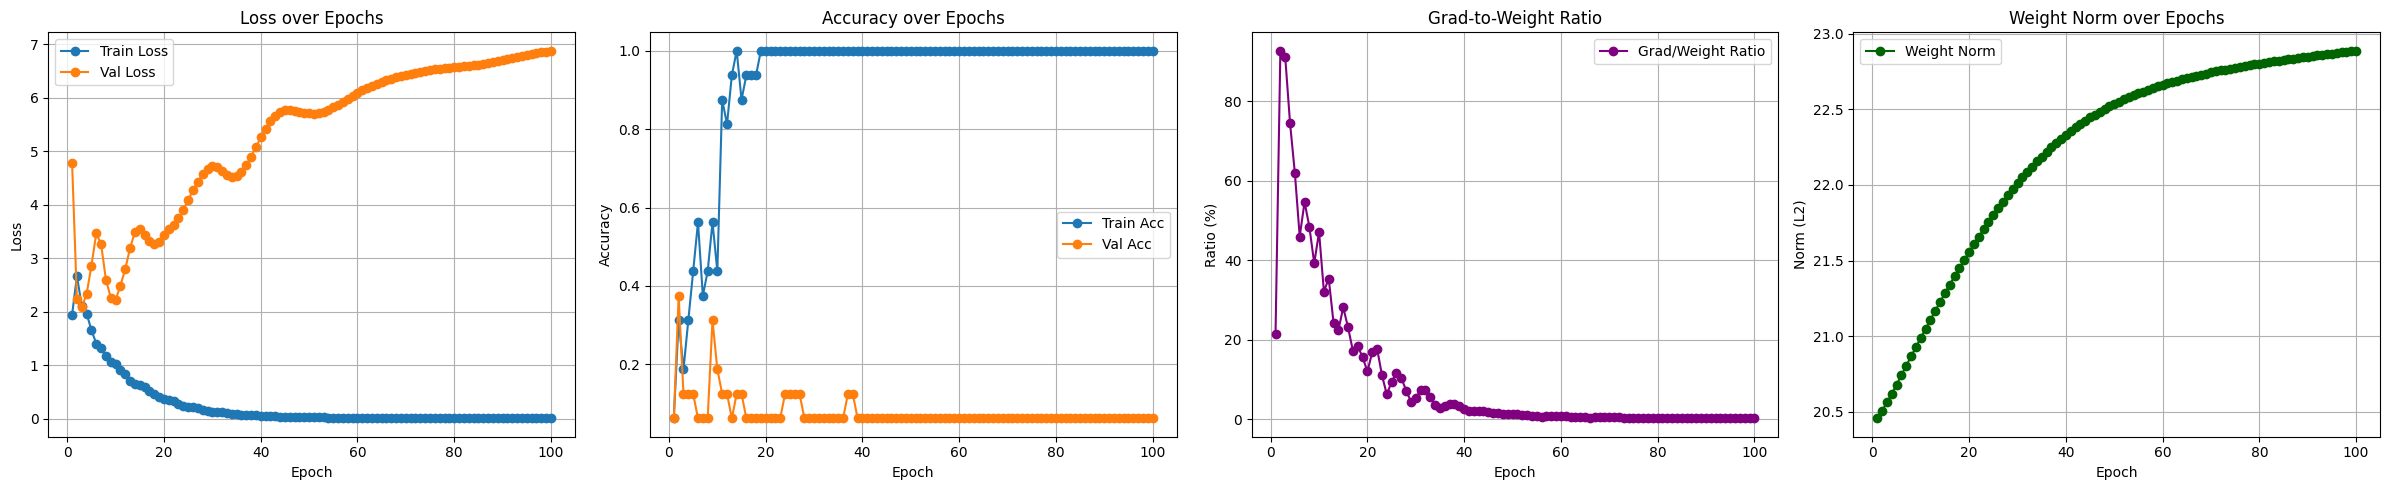

training

HEREHERHERHERHEHEhER
[Epoch 1/10] Batch 0/1436 - Loss: 1.8902 - Processed: 16 images - Grad/weight_ratio: 2252.20%
[Epoch 1/10] Batch 200/1436 - Loss: 1.8096 - Processed: 3216 images - Grad/weight_ratio: 3049.58%
[Epoch 1/10] Batch 400/1436 - Loss: 1.8161 - Processed: 6416 images - Grad/weight_ratio: 2378.43%
[Epoch 1/10] Batch 600/1436 - Loss: 1.7901 - Processed: 9616 images - Grad/weight_ratio: 2114.34%
[Epoch 1/10] Batch 800/1436 - Loss: 1.7665 - Processed: 12816 images - Grad/weight_ratio: 2025.55%
[Epoch 1/10] Batch 1000/1436 - Loss: 1.5362 - Processed: 16016 images - Grad/weight_ratio: 1953.21%
[Epoch 1/10] Batch 1200/1436 - Loss: 1.6686 - Processed: 19216 images - Grad/weight_ratio: 1885.75%
[Epoch 1/10] Batch 1400/1436 - Loss: 1.7480 - Processed: 22416 images - Grad/weight_ratio: 1843.36%


Traceback (most recent call last):
  File "<ipython-input-175-78b3559b8cd9>", line 20, in <cell line: 0>
    history = train_model(model, training_data, criterion, optimizer, config['epochs'], device, 2)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-173-46bb203c2645>", line 89, in train_model
    outputs = model(images)
              ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1739, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1845, in _call_impl
    return inner()
           ^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py", line 1806, in inner
    hook_result = hook(self, args, result)
                  ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/wandb

epoch_overfit,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
grad/weight_ratio_overfit,██▆▅▅▃▃▃▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc_overfit,▁▂▇▇▇███████████████████████████████████
train_loss_overfit,█▆▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc_overfit,█▂▂▁▁▁▂▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_overfit,▁▃▁▂▃▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█████████████
weight_norm_overfit,▁▁▂▂▂▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch_overfit,100
grad/weight_ratio_overfit,0.22248
train_acc_overfit,1
train_loss_overfit,0.00662


KeyboardInterrupt: 

In [ ]:
with wandb.init(project='emotion-recognition', config=config, name=(config['architecture']+'-run')):
  print('overfit\n')

  overfit_history = overfit(config, True)

  plot_training_history(overfit_history, True)
  wandb.log({"Overfit Training Curves": wandb.Image("training_plot_overfit.png")})

  print('training\n')

  model = get_model(config)
  optimizer = Adam(model.parameters(), lr=config['learning_rate'])
  criterion = nn.CrossEntropyLoss()

  training_data = {
      'train': to_loader(train, transform=transform, batch_size=config['batch_size']),
      'val': to_loader(val, transform=transform, batch_size=config['batch_size'])
  }

  history = train_model(model, training_data, criterion, optimizer, config['epochs'], device, 2)

  plot_training_history(history)

  wandb.log({"Training Curves": wandb.Image("training_plot.png")})

  torch.save(model.state_dict(), config['architecture'] + '.pt')
  wandb.save(config['architecture'] + '.pt')  # upload to W&B